# Style Transfer using VGG-16 Model

<hr>

## Introduction

We can maximize the feature activations inside a neural network so as to amplify patterns in the input image. This is called DeepDreaming.

This notebook uses a similar idea but takes two images as input: A content-image and a style-image. We then wish to create a mixed-image which has the contours of the content-image and the colours and texture of the style-image.

# Step 0 - what are we doing here?

- the basic idea in 2015 by the german researchers was to repurpose a fully trained convolutional network to help trasnfer the style between two images.
- we slice off the top layer since its used for classification and then 
- use the feature vectors at given layers to minimize the difference between two images
- tensorflow 1.0, python 3, numpy and matplotlib

# Step 1 - show style transfer examples for pics and videos

- video style transfer paper http://genekogan.com/works/style-transfer/
- introduces another loss function to minimize optical flow
- Optical flow is the pattern of apparent motion of objects, surfaces, and edges in a visual scene caused by the relative motion between an observer and a scene
- show video style transfer and gradual transform vidoe at the bottom

- Neural Doodle builds on this https://github.com/alexjc/neural-doodle creates semantic map using image segmentation

# Step 2 - what is this process?

- we want countour lines from content image
- we want and textures from style image
- whats in a filter? https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks/
- each conv layer has as many 3D filters as we set. could be 1. could be 20.
- normally used to identify if features exist for classification
- i.e minimize loss between labeled image and feature map output
- each filter performs operation on input
- outputs 3D feature map/activation map. 
- start with random noise for mixed image
- calculate different loss functions at different layers
- weigh these loss functions respectively
- gradient of combined loss functions to update mixed image
- we do this 100-1000 times until image is mixed


content loss
--------
- calculate features/values at higher layer 
- minimize difference between activation features between content and  -- mixed image. calculate mean squared error. that is loss function. we want to minimize this.

- we cache the feature from content image because we don't need to recalculate that. 

style loss
--------
- multiple layers 
- minimize difference between gram matrix for layer 1 and 2 for style and mixed image



## Flowchart

This flowchart shows roughly the idea of the Style Transfer algorithm, although we use the VGG-16 model which has many more layers than shown here.

Two images are input to the neural network: A content-image and a style-image. We wish to generate the mixed-image which has the contours of the content-image and the colours and texture of the style-image.
We do this by creating several loss-functions that can be optimized.

The loss-function for the content-image tries to minimize the difference between the features that are activated for the content-image and for the mixed-image, at one or more layers in the network. This causes the contours of the mixed-image to resemble those of the content-image.

The loss-function for the style-image is slightly more complicated, because it instead tries to minimize the difference between the so-called Gram-matrices for the style-image and the mixed-image. This is done at one or more layers in the network. The Gram-matrix measures which features are activated simultaneously in a given layer. Changing the mixed-image so that it mimics the activation patterns of the style-image causes the colour and texture to be transferred.

We use TensorFlow to automatically derive the gradient for these loss-functions. The gradient is then used to update the mixed-image. This procedure is repeated a number of times until we are satisfied with the resulting image.

There are some details of the Style Transfer algorithm not shown in this flowchart, e.g. regarding calculation of the Gram-matrices, calculation and storage of intermediate values for efficiency, a loss-function for denoising the mixed-image, and normalization of the loss-functions so they are easier to scale relative to each other.

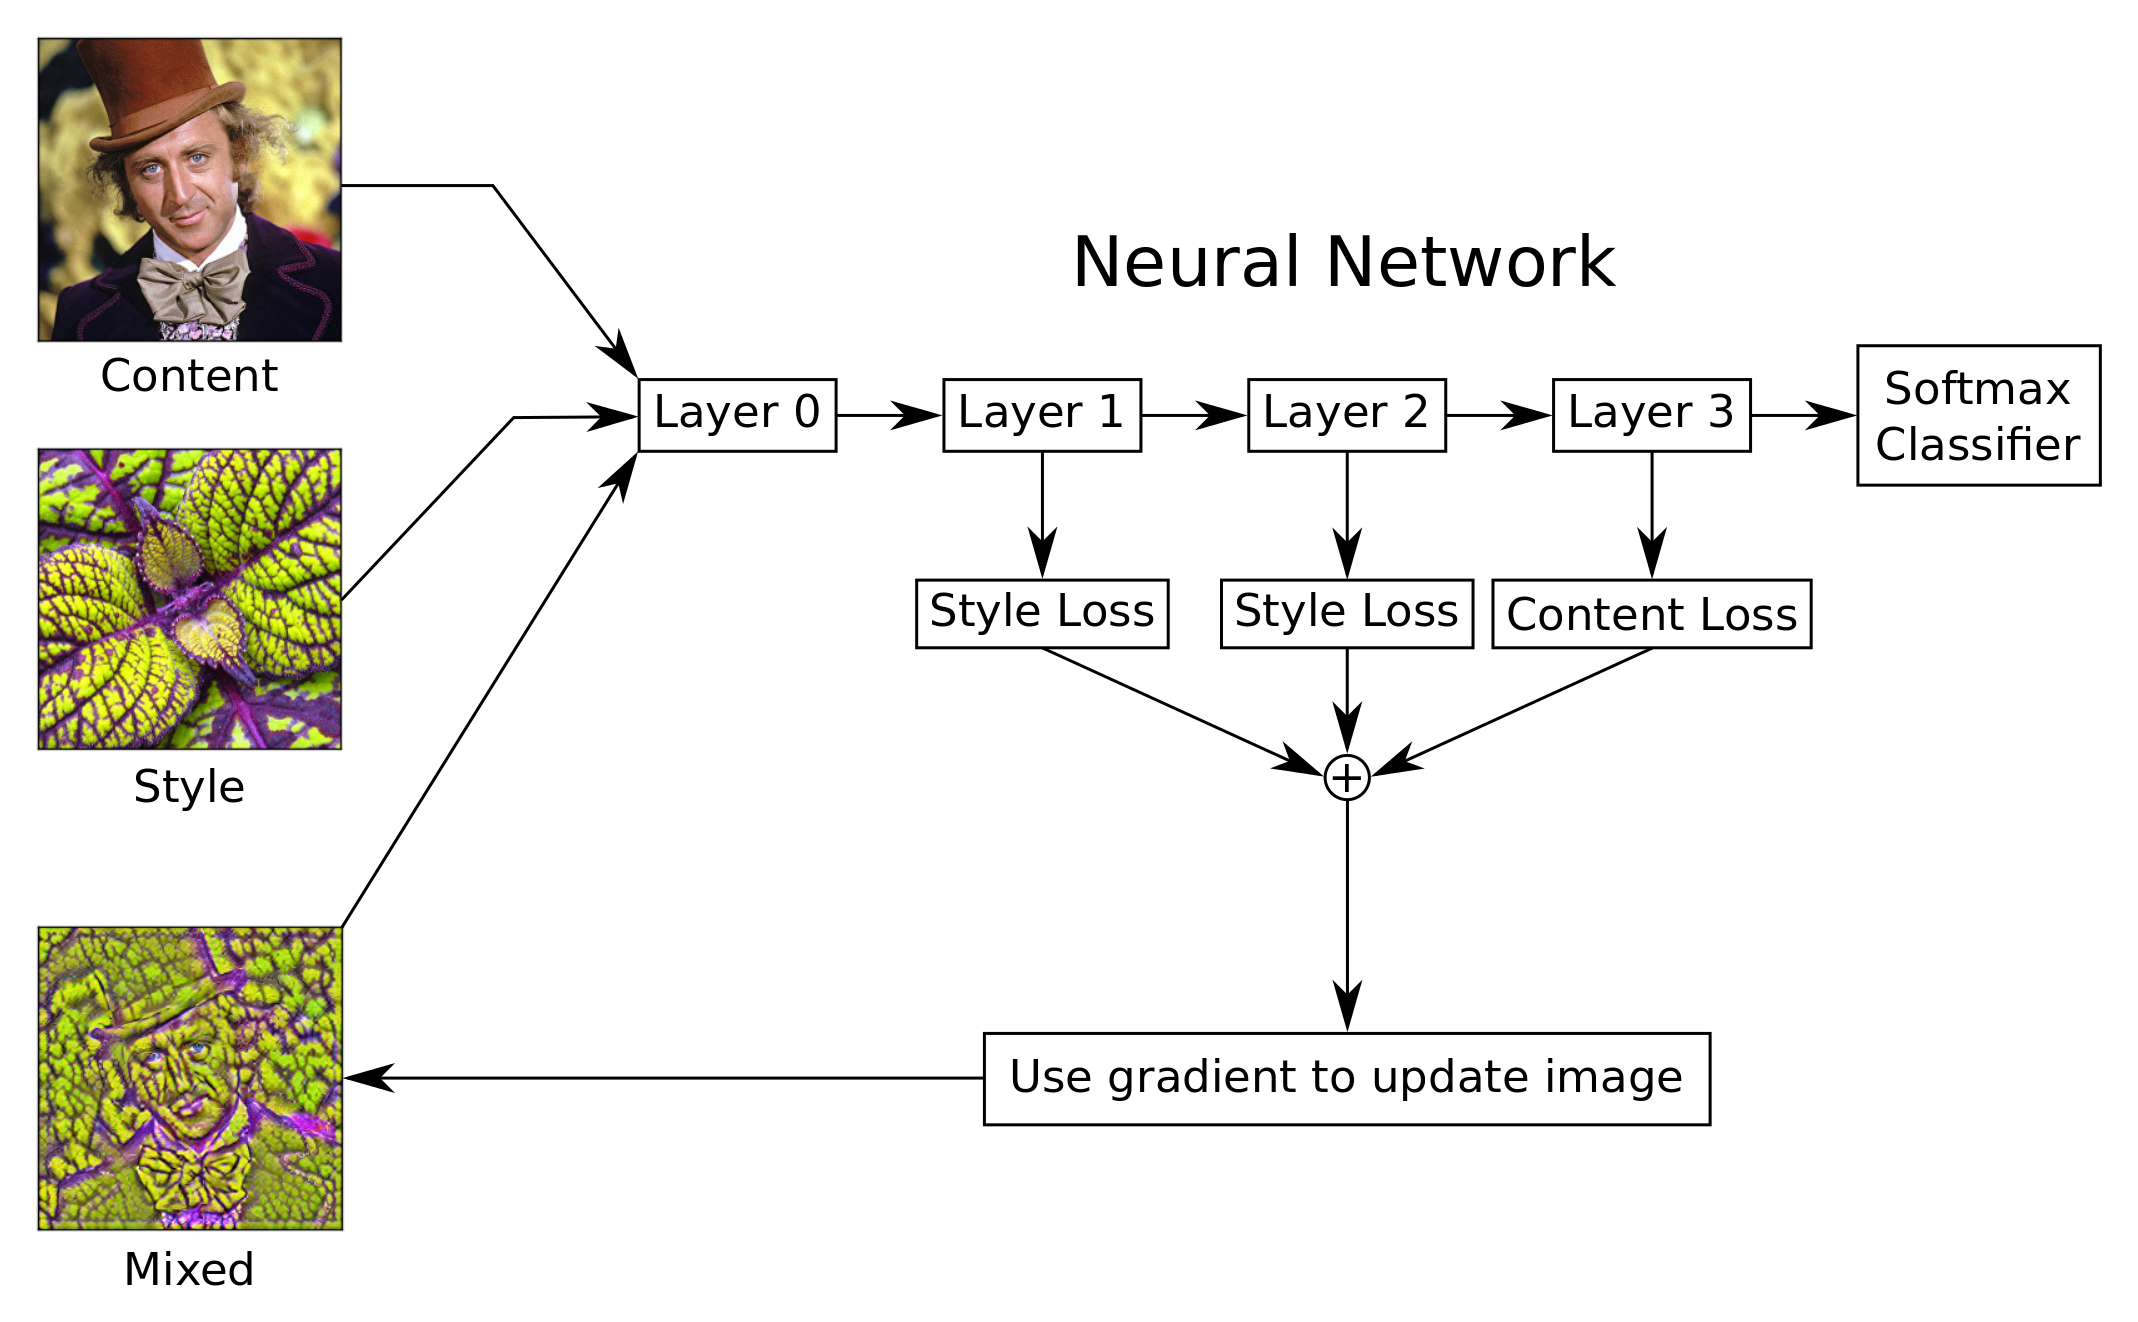

In [1]:
from IPython.display import Image, display
Image('images/15_style_transfer_flowchart.png')

## Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import PIL.Image

This was developed using Python 3.5.2 (Anaconda) and TensorFlow version:

In [3]:
tf.__version__

'1.0.1'

## VGG-16 Model

After having spent 2 days trying to get the style-transfer algorithm to work with the Inception 5h model that we used for DeepDreaming in Tutorial #14, I could not produce images that looked any good. This seems strange because the images that were produced in Tutorial #14 looked quite nice. But recall that we also used a few tricks to achieve that quality, such as smoothing the gradient and recursively downscaling and processing the image.

The [original paper](https://arxiv.org/abs/1508.06576) on style transfer used the VGG-19 convolutional neural network. But the pre-trained VGG-19 models for TensorFlow did not seem suitable for this tutorial for different reasons. Instead we will use the VGG-16 model, which someone else has made available and which can easily be loaded in TensorFlow. We have wrapped it in a class for convenience.

In [4]:
import vgg16

The VGG-16 model is downloaded from the internet. This is the default directory where you want to save the data-files. The directory will be created if it does not exist.

In [5]:
vgg16.data_dir = 'vgg16/'

Download the data for the VGG-16 model if it doesn't already exist in the directory.

**WARNING: It is 550 MB!**

In [6]:
vgg16.maybe_download()

Data has apparently already been downloaded and unpacked.


## Helper-functions for image manipulation

This function loads an image and returns it as a numpy array of floating-points. The image can be automatically resized so the largest of the height or width equals `max_size`.

In [7]:
def load_image(filename, max_size=None):
    image = PIL.Image.open(filename)

    if max_size is not None:
        # Calculate the appropriate rescale-factor for
        # ensuring a max height and width, while keeping
        # the proportion between them.
        factor = max_size / np.max(image.size)
    
        # Scale the image's height and width.
        size = np.array(image.size) * factor

        # The size is now floating-point because it was scaled.
        # But PIL requires the size to be integers.
        size = size.astype(int)

        # Resize the image.
        image = image.resize(size, PIL.Image.LANCZOS)

    # Convert to numpy floating-point array.
    return np.float32(image)

Save an image as a jpeg-file. The image is given as a numpy array with pixel-values between 0 and 255.

In [8]:
def save_image(image, filename):
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)
    
    # Convert to bytes.
    image = image.astype(np.uint8)
    
    # Write the image-file in jpeg-format.
    with open(filename, 'wb') as file:
        PIL.Image.fromarray(image).save(file, 'jpeg')

This function plots a large image. The image is given as a numpy array with pixel-values between 0 and 255.

In [9]:
def plot_image_big(image):
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)

    # Convert pixels to bytes.
    image = image.astype(np.uint8)

    # Convert to a PIL-image and display it.
    display(PIL.Image.fromarray(image))

This function plots the content-, mixed- and style-images.

In [10]:
def plot_images(content_image, style_image, mixed_image):
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Use interpolation to smooth pixels?
    smooth = True
    
    # Interpolation type.
    if smooth:
        interpolation = 'sinc'
    else:
        interpolation = 'nearest'

    # Plot the content-image.
    # Note that the pixel-values are normalized to
    # the [0.0, 1.0] range by dividing with 255.
    ax = axes.flat[0]
    ax.imshow(content_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Content")

    # Plot the mixed-image.
    ax = axes.flat[1]
    ax.imshow(mixed_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Mixed")

    # Plot the style-image
    ax = axes.flat[2]
    ax.imshow(style_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Style")

    # Remove ticks from all the plots.
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Loss Functions

These helper-functions create the loss-functions that are used in optimization with TensorFlow.

This function creates a TensorFlow operation for calculating the Mean Squared Error between the two input tensors.

In [11]:
#average of the squre of the errors. 
#between output values for both images at a given layer
#The smaller the means squared error, the closer you are to finding the line of best fit. 
# square the difference between both output feature map/activation map
# and average all those values by adding all then dividing by n 
# https://www.tensorflow.org/api_docs/python/tf/reduce_mean
def mean_squared_error(a, b):
    return tf.reduce_mean(tf.square(a - b))

This function creates the loss-function for the content-image. It is the Mean Squared Error of the feature activations in the given layers in the model, between the content-image and the mixed-image. When this content-loss is minimized, it therefore means that the mixed-image has feature activations in the given layers that are very similar to the activations of the content-image. Depending on which layers you select, this should transfer the contours from the content-image to the mixed-image.

In [12]:
#step 3 - content image is 3d numpy array, indices for the layers
#we want to use for content loss
#you should expirment what looks good for different layers
#there is not one best layer, we haven't found a way to minimize
#loss for beauty. how to quantify?
def create_content_loss(session, model, content_image, layer_ids):
    """
    Create the loss-function for the content-image.
    
    Parameters:
    session: An open TensorFlow session for running the model's graph.
    model: The model, e.g. an instance of the VGG16-class.
    content_image: Numpy float array with the content-image.
    layer_ids: List of integer id's for the layers to use in the model.
    """
    
    #A python dictionary object is generated with the 
    # placeholders as keys and the representative feed 
    #tensors as values.
    # Create a feed-dict with the content-image.
    feed_dict = model.create_feed_dict(image=content_image)

    # Get references to the tensors for the given layers.
    # collection of filters
    layers = model.get_layer_tensors(layer_ids)

    # Calculate the output values of those layers when
    # feeding the content-image to the model.
    values = session.run(layers, feed_dict=feed_dict)

    # Set the model's graph as the default so we can add
    # computational nodes to it. It is not always clear
    # when this is necessary in TensorFlow, but if you
    # want to re-use this code then it may be necessary.
    with model.graph.as_default():
        # Initialize an empty list of loss-functions.
        #because we are calculating losses per layer
        layer_losses = []
    
        # For each layer and its corresponding values
        # for the content-image.
        for value, layer in zip(values, layers):
            # These are the values that are calculated
            # for this layer in the model when inputting
            # the content-image. Wrap it to ensure it
            # is a const - although this may be done
            # automatically by TensorFlow.
            value_const = tf.constant(value)

            # The loss-function for this layer is the
            # Mean Squared Error between the layer-values
            # when inputting the content- and mixed-images.
            # Note that the mixed-image is not calculated
            # yet, we are merely creating the operations
            # for calculating the MSE between those two.
            loss = mean_squared_error(layer, value_const)

            # Add the loss-function for this layer to the
            # list of loss-functions.
            layer_losses.append(loss)

        # The combined loss for all layers is just the average.
        # The loss-functions could be weighted differently for
        # each layer. You can try it and see what happens.
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

We will do something similar for the style-layers, but now we want to measure which features in the style-layers activate simultaneously for the style-image, and then copy this activation-pattern to the mixed-image.

One way of doing this, is to calculate the so-called Gram-matrix for the tensors output by the style-layers. The Gram-matrix is essentially just a matrix of dot-products for the vectors of the feature activations of a style-layer.

If an entry in the Gram-matrix has a value close to zero then it means the two features in the given layer do not activate simultaneously for the given style-image. And vice versa, if an entry in the Gram-matrix has a large value, then it means the two features do activate simultaneously for the given style-image. We will then try and create a mixed-image that replicates this activation pattern of the style-image.

This is the helper-function for calculating the Gram-matrix of a tensor output by a convolutional layer in the neural network. The actual loss-function is created further below.

In [13]:
#The Gram matrix, defined as https://i.stack.imgur.com/tU9ow.png 
#is used to 
#measure the correlation between channels after flattening the 
#filter images into vectors

#Gatys when asked why gram matrix at a talk was that the 
#Gram matrix encodes second 
#order statistics of the set of filters.
#it sort of mushes up all the features at a given layer, 
#tossing spatial information in favor of a measure of 
#how the different features are correlated 

def gram_matrix(tensor):
    #gram matrix is vector of dot products for vectors
    #of the feature activations of a style layer
    
    #4d tensor from convolutional layer
    shape = tensor.get_shape()
    
    # Get the number of feature channels for the input tensor,
    # which is assumed to be from a convolutional layer with 4-dim.
    num_channels = int(shape[3])

    #-1 means whatever number makes the data fit 
    # Reshape the tensor so it is a 2-dim matrix. This essentially
    # flattens the contents of each feature-channel.
    matrix = tf.reshape(tensor, shape=[-1, num_channels])
    
    
    #gram matrix is transpose matrix with itself
    #so each entry in gram matrix
    #tells us if a feature channel has a tendency
    #to be activated with another feature channel
    
    #idea is to make the mixed image match patterns from style image
    
    
    # Calculate the Gram-matrix as the matrix-product of
    # the 2-dim matrix with itself. This calculates the
    # dot-products of all combinations of the feature-channels.
    gram = tf.matmul(tf.transpose(matrix), matrix)

    return gram                            

The next function creates the loss-function for the style-image. It is quite similar to `create_content_loss()` above, except that we calculate the Mean Squared Error for the Gram-matrices instead of the raw tensor-outputs from the layers.

In [14]:
def create_style_loss(session, model, style_image, layer_ids):
    """
    Create the loss-function for the style-image.
    
    Parameters:
    session: An open TensorFlow session for running the model's graph.
    model: The model, e.g. an instance of the VGG16-class.
    style_image: Numpy float array with the style-image.
    layer_ids: List of integer id's for the layers to use in the model.
    """

    # Create a feed-dict with the style-image.
    feed_dict = model.create_feed_dict(image=style_image)

    # Get references to the tensors for the given layers.
    layers = model.get_layer_tensors(layer_ids)

    # Set the model's graph as the default so we can add
    # computational nodes to it. It is not always clear
    # when this is necessary in TensorFlow, but if you
    # want to re-use this code then it may be necessary.
    with model.graph.as_default():
        # Construct the TensorFlow-operations for calculating
        # the Gram-matrices for each of the layers.
        gram_layers = [gram_matrix(layer) for layer in layers]

        # Calculate the values of those Gram-matrices when
        # feeding the style-image to the model.
        values = session.run(gram_layers, feed_dict=feed_dict)

        # Initialize an empty list of loss-functions.
        layer_losses = []
    
        # For each Gram-matrix layer and its corresponding values.
        for value, gram_layer in zip(values, gram_layers):
            # These are the Gram-matrix values that are calculated
            # for this layer in the model when inputting the
            # style-image. Wrap it to ensure it is a const,
            # although this may be done automatically by TensorFlow.
            value_const = tf.constant(value)

            # The loss-function for this layer is the
            # Mean Squared Error between the Gram-matrix values
            # for the content- and mixed-images.
            # Note that the mixed-image is not calculated
            # yet, we are merely creating the operations
            # for calculating the MSE between those two.
            
            
            #between gram matrix and value of gram matrix when inputting 
            #style image
            
            loss = mean_squared_error(gram_layer, value_const)

            # Add the loss-function for this layer to the
            # list of loss-functions.
            layer_losses.append(loss)

        # The combined loss for all layers is just the average.
        # The loss-functions could be weighted differently for
        # each layer. You can try it and see what happens.
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

This creates the loss-function for denoising the mixed-image. The algorithm is called [Total Variation Denoising](https://en.wikipedia.org/wiki/Total_variation_denoising) and essentially just shifts the image one pixel in the x- and y-axis, calculates the difference from the original image, takes the absolute value to ensure the difference is a positive number, and sums over all the pixels in the image. This creates a loss-function that can be minimized so as to suppress some of the noise in the image.

In [15]:
#shifts input image by 1 pixel on x and y axis 
#calculate difference between shifted and original image
#absolute value to make positive
#calculate sum of pixels in those images
#helps suppress noise in mixed image we are generating



def create_denoise_loss(model):
    loss = tf.reduce_sum(tf.abs(model.input[:,1:,:,:] - model.input[:,:-1,:,:])) + \
           tf.reduce_sum(tf.abs(model.input[:,:,1:,:] - model.input[:,:,:-1,:]))

    return loss

## Style-Transfer Algorithm

This is the main optimization algorithm for the Style-Transfer algorithm. It is basically just gradient descent on the loss-functions defined above.

This algorithm also uses normalization of the loss-functions. This appears to be a novel idea not previously published. In each iteration of the optimization, the loss-values are adjusted so each of them equals one. This allows the user to set the loss-weights independently of the chosen style- and content-layers. It also adapts the weighting during optimization to ensure the desired ratio between style, content and denoising is preserved.

In [16]:
#relative weights - normalized.
#style should have more weight than content
def style_transfer(content_image, style_image,
                   content_layer_ids, style_layer_ids,
                   weight_content=1.5, weight_style=10.0,
                   weight_denoise=0.3,
                   num_iterations=120, step_size=10.0):
    """
    Use gradient descent to find an image that minimizes the
    loss-functions of the content-layers and style-layers. This
    should result in a mixed-image that resembles the contours
    of the content-image, and resembles the colours and textures
    of the style-image.
    
    Parameters:
    content_image: Numpy 3-dim float-array with the content-image.
    style_image: Numpy 3-dim float-array with the style-image.
    content_layer_ids: List of integers identifying the content-layers.
    style_layer_ids: List of integers identifying the style-layers.
    weight_content: Weight for the content-loss-function.
    weight_style: Weight for the style-loss-function.
    weight_denoise: Weight for the denoising-loss-function.
    num_iterations: Number of optimization iterations to perform.
    step_size: Step-size for the gradient in each iteration.
    """

    # Create an instance of the VGG16-model. This is done
    # in each call of this function, because we will add
    # operations to the graph so it can grow very large
    # and run out of RAM if we keep using the same instance.
    model = vgg16.VGG16()

    # Create a TensorFlow-session.
    session = tf.InteractiveSession(graph=model.graph)

    # Print the names of the content-layers.
    print("Content layers:")
    print(model.get_layer_names(content_layer_ids))
    print()

    # Print the names of the style-layers.
    print("Style layers:")
    print(model.get_layer_names(style_layer_ids))
    print()

    # Create the loss-function for the content-layers and -image.
    loss_content = create_content_loss(session=session,
                                       model=model,
                                       content_image=content_image,
                                       layer_ids=content_layer_ids)

    # Create the loss-function for the style-layers and -image.
    loss_style = create_style_loss(session=session,
                                   model=model,
                                   style_image=style_image,
                                   layer_ids=style_layer_ids)    

    # Create the loss-function for the denoising of the mixed-image.
    loss_denoise = create_denoise_loss(model)

    
    #adjust levels of loss functions, normalize them
    #multiply them with a variable
    #taking reciprocal values of loss values of content, style, denoising
    #small constant to avoid divide by 0
    #adjustment value normalizes loss so approximately 1
    #weights should be set relative to each other dont depend on layers
    #we are using
    
    # Create TensorFlow variables for adjusting the values of
    # the loss-functions. This is explained below.
    adj_content = tf.Variable(1e-10, name='adj_content')
    adj_style = tf.Variable(1e-10, name='adj_style')
    adj_denoise = tf.Variable(1e-10, name='adj_denoise')

    # Initialize the adjustment values for the loss-functions.
    session.run([adj_content.initializer,
                 adj_style.initializer,
                 adj_denoise.initializer])

    # Create TensorFlow operations for updating the adjustment values.
    # These are basically just the reciprocal values of the
    # loss-functions, with a small value 1e-10 added to avoid the
    # possibility of division by zero.
    update_adj_content = adj_content.assign(1.0 / (loss_content + 1e-10))
    update_adj_style = adj_style.assign(1.0 / (loss_style + 1e-10))
    update_adj_denoise = adj_denoise.assign(1.0 / (loss_denoise + 1e-10))

    # This is the weighted loss-function that we will minimize
    # below in order to generate the mixed-image.
    # Because we multiply the loss-values with their reciprocal
    # adjustment values, we can use relative weights for the
    # loss-functions that are easier to select, as they are
    # independent of the exact choice of style- and content-layers.
    loss_combined = weight_content * adj_content * loss_content + \
                    weight_style * adj_style * loss_style + \
                    weight_denoise * adj_denoise * loss_denoise

    # Use TensorFlow to get the mathematical function for the
    # gradient of the combined loss-function with regard to
    # the input image. (mixed)
    gradient = tf.gradients(loss_combined, model.input)

    # List of tensors that we will run in each optimization iteration.
    run_list = [gradient, update_adj_content, update_adj_style, \
                update_adj_denoise]

    # The mixed-image is initialized with random noise.
    # It is the same size as the content-image.
    #where we first init it
    mixed_image = np.random.rand(*content_image.shape) + 128

    for i in range(num_iterations):
        # Create a feed-dict with the mixed-image.
        feed_dict = model.create_feed_dict(image=mixed_image)

        # Use TensorFlow to calculate the value of the
        # gradient, as well as updating the adjustment values.
        grad, adj_content_val, adj_style_val, adj_denoise_val \
        = session.run(run_list, feed_dict=feed_dict)

        # Reduce the dimensionality of the gradient.
        #Remove single-dimensional entries from the shape of an array.
        grad = np.squeeze(grad)

        # Scale the step-size according to the gradient-values.
        #Ratio of weights:updates
        #akin to learning rate
        step_size_scaled = step_size / (np.std(grad) + 1e-8)

        # Update the image by following the gradient.
        #gradient descent
        mixed_image -= grad * step_size_scaled

        # Ensure the image has valid pixel-values between 0 and 255.
        #Given an interval, values outside the interval are clipped 
        #to the interval edges.
        mixed_image = np.clip(mixed_image, 0.0, 255.0)

        # Print a little progress-indicator.
        print(". ", end="")

        # Display status once every 10 iterations, and the last.
        if (i % 10 == 0) or (i == num_iterations - 1):
            print()
            print("Iteration:", i)

            # Print adjustment weights for loss-functions.
            msg = "Weight Adj. for Content: {0:.2e}, Style: {1:.2e}, Denoise: {2:.2e}"
            print(msg.format(adj_content_val, adj_style_val, adj_denoise_val))

            #in larger resolution
            # Plot the content-, style- and mixed-images.
            plot_images(content_image=content_image,
                        style_image=style_image,
                        mixed_image=mixed_image)
            
    print()
    print("Final image:")
    plot_image_big(mixed_image)

    # Close the TensorFlow session to release its resources.
    session.close()
    
    # Return the mixed-image.
    return mixed_image

## Example

This example shows how to transfer the style of various images onto a portrait.

First we load the content-image which has the overall contours that we want in the mixed-image.

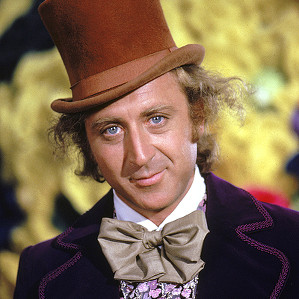

In [17]:
content_filename = 'images/willy_wonka_old.jpg'
content_image = load_image(content_filename, max_size=None)

Image('images/willy_wonka_old.jpg')

Then we load the style-image which has the colours and textures we want in the mixed-image.

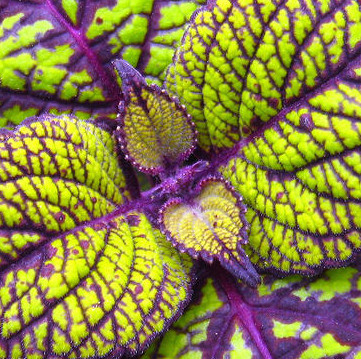

In [18]:
style_filename = 'images/style7.jpg'
style_image = load_image(style_filename, max_size=300)

Image('images/style7.jpg')

Then we define a list of integers which identify the layers in the neural network that we want to use for matching the content-image. These are indices into the layers in the neural network. For the VGG16 model, the 5th layer (index 4) seems to work well as the sole content-layer.

In [19]:
content_layer_ids = [4]

Then we define another list of integers for the style-layers.

In [ ]:
# The VGG16-model has 13 convolutional layers.
# This selects all those layers as the style-layers.
# This is somewhat slow to optimize.
style_layer_ids = list(range(13))

# You can also select a sub-set of the layers, e.g. like this:
style_layer_ids = [1, 2, 3, 4]


# Notes

- minimize MSE between content image and mixed image for content layers
- minimize MSE between gram matrix of style layers between style image and mixed image

Now perform the style-transfer. This automatically creates the appropriate loss-functions for the style- and content-layers, and then performs a number of optimization iterations. This will gradually create a mixed-image which has similar contours as the content-image, with the colours and textures being similar to the style-image.

This can be very slow on a CPU!

In [ ]:
%%time
img = style_transfer(content_image=content_image,
                     style_image=style_image,
                     content_layer_ids=content_layer_ids,
                     style_layer_ids=style_layer_ids,
                     weight_content=1.5,
                     weight_style=10.0,
                     weight_denoise=0.3,
                     num_iterations=60,
                     step_size=10.0)

Content layers:
['conv3_1/conv3_1']

Style layers:
['conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1']



## References : 

The VGG 16 model: https://github.com/pkmital/CADL/blob/master/session-4/libs/vgg16.py

The majority of this code is taken from the [TensorFlow-Tutorials](https://github.com/Hvass-Labs/TensorFlow-Tutorials). I highly recommend them to those who want to get started with TensorFlow.

<hr>